# Practica Análisis de sentimiento

### Importamos num2words

In [637]:
!pip install num2words

### Librerías necesarias

In [638]:
import random
import numpy as np
import pandas as pd
import gensim
import unicodedata
import string
from num2words import num2words
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from collections import Counter
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve

import matplotlib.pyplot as plt

### Carga de datos

In [639]:
df1 = pd.read_json('../../archivos/Automotive_5.json',lines=True)
df2 = pd.read_json('../../archivos/Video_Games_5.json',lines=True)
df3 = pd.read_json('../../archivos/Baby_5.json',lines=True)
df4 = pd.read_json('../../archivos/Home_and_Kitchen_5.json',lines=True)
df5 = pd.read_json('../../archivos/Sports_and_Outdoors_5.json',lines=True)

In [640]:
df1=df1[:20000]
print('el df1 tiene',df1.shape)
df2=df2[:20000]
print('el df2 tiene',df2.shape)
df3=df3[:20000]
print('el df3 tiene',df3.shape)
df4=df4[:20000]
print('el df4 tiene',df4.shape)
df5=df5[:20000]
print('el df5 tiene',df5.shape)

el df1 tiene (20000, 9)
el df2 tiene (20000, 9)
el df3 tiene (20000, 9)
el df4 tiene (20000, 9)
el df5 tiene (20000, 9)


In [641]:
df=pd.concat([df1, df2, df3, df4,df5], axis=0)
df = shuffle(df)

In [642]:
df.shape

(100000, 9)

In [643]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
15846,A2275FQ5V1S5YZ,B0007IS74G,Eric L,"[0, 0]",Super easy to put together. With a little bit ...,4,Easy to assemble,1362009600,"02 28, 2013"
2430,A38353GFTVATJR,B0006N5RYK,BG,"[0, 0]",Nice tight fit on my camper van. Since I have...,5,Awesome!,1402012800,"06 6, 2014"
9097,A1Z4GKIZ8IRN8G,B00004RGAW,NaN,"[0, 0]",The fryer is well built with several improveme...,5,DeLonghi D895UX cool touch electric fryer,1211068800,"05 18, 2008"
1595,A3QDPQBJAJC6C,B0002UQAM0,Jaco,"[0, 2]",Not really impressed with this product. The Me...,2,"Bleh, over rated",1390780800,"01 27, 2014"
11392,AFZKJP8I0PO3X,B0002N3OMG,"wilepi ""lisa""","[0, 0]",While they bill this swaddling wrap for sleepi...,5,not just for sleeping!!,1136419200,"01 5, 2006"


# Probamos el modelo sin los review de 3

In [644]:
df = df.drop(df[df['overall']==3].index)

In [645]:
def label_sentiment(row):
    if int(row['overall']) < 3:
        return 'negativo'
    else:
        return 'positivo'

In [646]:
df.overall.value_counts()

5    44085
4    14170
2     3136
1     2954
Name: overall, dtype: int64

In [647]:
df['sentiment_label'] = df.apply(lambda row: label_sentiment(row), axis=1)
df.drop(['reviewerID', 'asin', 'reviewerName', 'helpful', 'summary', 'unixReviewTime', 'reviewTime'], axis=1, inplace=True)

In [648]:
df.head()

,reviewText,overall,sentiment_label
2430,Nice tight fit on my camper van. Since I have...,5,positivo
9097,The fryer is well built with several improveme...,5,positivo
1595,Not really impressed with this product. The Me...,2,negativo
11392,While they bill this swaddling wrap for sleepi...,5,positivo
14199,Final Fantasy IX is my most favorite in the se...,5,positivo


### Pipeline

In [649]:
def text_normalizer(text, lemmatize=False, sw_list=None):
    
    processed_text = []
    
    if sw_list is None:
        sw_list = []
    
    if lemmatize:
        lemmas_dict = get_lemmas_dict()
    
    # Convierte el texto a minúsuculas
    text = text.lower()
    
    # Eliminar caracteres "extraños"
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    # Tabla para eliminar signos de puntuación
    table = str.maketrans('', '', string.punctuation)
    
    # Segmentar texto en frases
    sentences = text.split('.')
    
    # Para cada frase
    for sentence in sentences:
        words = sentence.split(' ')
        # Para cada palabra
        for word in words:
            if word not in string.punctuation and word not in sw_list:  # Si se pasa, elimina stop words
                word = word.translate(table)
                if lemmatize:
                    word = lemmas_dict.get(word, word)
                if word.isdigit():
                    word = num2words(word, lang='en')
            processed_text.append(word)
    
    return ' '.join(processed_text)
    

In [650]:
for text in df['reviewText']:
    text_normalizer(text)

### Separamos en conjunto de train y test

In [651]:
X_train, X_test, y_train, y_test = train_test_split(
    df['reviewText'],
    df['sentiment_label'],
    train_size=0.80,
    test_size=0.20,
    shuffle=True
)

### Extracción de features

In [652]:
cv = TfidfVectorizer(
    max_df=0.95,
    min_df=5,
    max_features=2500,
    strip_accents='ascii',
    #ngram_range=(1, 1)
    ngram_range=(1, 2) # con este ngram es con el que mejor resultado he obtenido en este modelo
    #ngram_range=(2, 3)
)
cv.fit(X_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.95, max_features=2500,
                min_df=5, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents='ascii',
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

### TF-IDF scores del training set y test set

In [653]:
X_train_ = cv.transform(X_train)
X_test_ = cv.transform(X_test)

### $\chi²$ scores

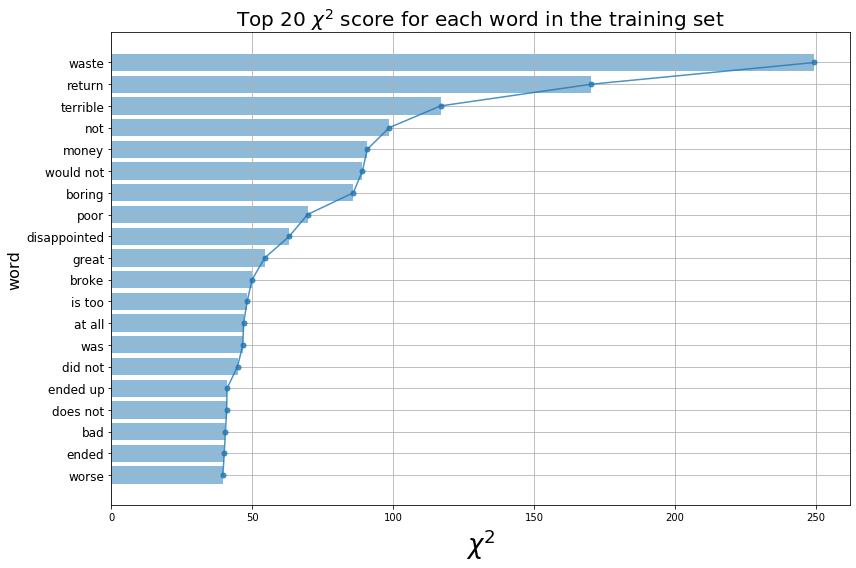

In [654]:
# Compute the chi-squared score for each word in the training set and show the values
i = 20

chi2score = chi2(X_train_, y_train)[0]
scores = list(zip(cv.get_feature_names(), chi2score))
sorted_scores = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*sorted_scores[-i:]))
x = range(len(topchi2[1]))
labels = topchi2[0]

plt.figure(figsize=(12, 8))
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels, fontsize=12)
plt.xlabel('$\chi^2$', fontsize=26)
plt.ylabel('word', fontsize=16)
plt.title('Top {} $\chi^2$ score for each word in the training set'.format(i), fontsize=20)
plt.grid()
plt.tight_layout()
plt.show();

### Entrenamiento

In [655]:
c_params = [0.01, 0.05, 0.25, 0.5, 1, 2, 5, 10, 100]

train_acc = list()
test_acc = list()
for c in c_params:
    lr = LogisticRegression(C=c, solver='lbfgs', max_iter=500)
    lr.fit(X_train_, y_train)
    
    train_predict = lr.predict(X_train_)
    test_predict = lr.predict(X_test_)
    
    print ("Accuracy for C={}: {}".format(c, accuracy_score(y_test, test_predict)))
    
    train_acc.append(accuracy_score(y_train, train_predict))
    test_acc.append(accuracy_score(y_test, test_predict))

Accuracy for C=0.01: 0.9075297225891678
Accuracy for C=0.05: 0.9075297225891678
Accuracy for C=0.25: 0.9189525215634471
Accuracy for C=0.5: 0.9278887248426451
Accuracy for C=1: 0.9342606263112907
Accuracy for C=2: 0.9370580464682571
Accuracy for C=5: 0.9381459320848551
Accuracy for C=10: 0.9374465770456135
Accuracy for C=100: 0.9329396223482788


### Algunas métricas

In [656]:
print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, test_predict)))
print('\nClassification report:\n{}'.format(classification_report(y_test, test_predict)))
print('Accuracy score:{}'.format(accuracy_score(y_test, test_predict)))

Confussion matrix:
[[  646   544]
 [  319 11360]]

Classification report:
              precision    recall  f1-score   support

    negativo       0.67      0.54      0.60      1190
    positivo       0.95      0.97      0.96     11679

    accuracy                           0.93     12869
   macro avg       0.81      0.76      0.78     12869
weighted avg       0.93      0.93      0.93     12869

Accuracy score:0.9329396223482788


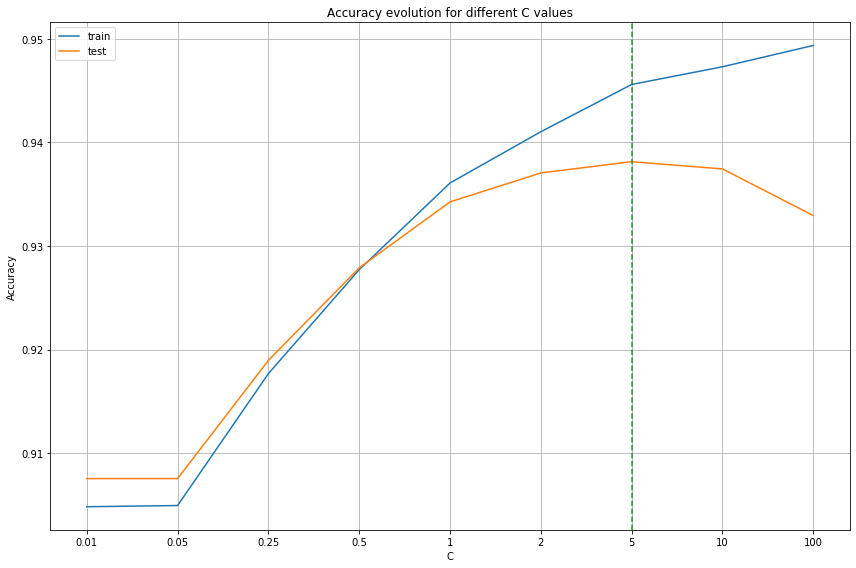

In [657]:
plt.figure(figsize=(12, 8))
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.axvline(np.argmax(test_acc), c='g', ls='--', alpha=0.8)
plt.title('Accuracy evolution for different C values')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.xticks(list(range(len(c_params))), c_params)
plt.tight_layout()
plt.show()

### Predict

In [658]:
def predict_review_sentiment(review_index, model):
    print('Actual sentiment: {}'.format(df.iloc[review_index]['sentiment_label']))
    r = df.iloc[review_index]['reviewText']
    print('Prediction: {}'.format(lr.predict(cv.transform([r]))))

In [659]:
for i in random.sample(range(0, len(df)), 10):
    print('\nReview no. {}'.format(i))
    predict_review_sentiment(i, lr)


Review no. 19915
Actual sentiment: positivo
Prediction: ['positivo']

Review no. 63172
Actual sentiment: positivo
Prediction: ['positivo']

Review no. 13494
Actual sentiment: positivo
Prediction: ['positivo']

Review no. 52968
Actual sentiment: negativo
Prediction: ['positivo']

Review no. 25505
Actual sentiment: positivo
Prediction: ['positivo']

Review no. 2812
Actual sentiment: positivo
Prediction: ['positivo']

Review no. 1910
Actual sentiment: positivo
Prediction: ['positivo']

Review no. 61172
Actual sentiment: positivo
Prediction: ['positivo']

Review no. 13806
Actual sentiment: positivo
Prediction: ['positivo']

Review no. 63969
Actual sentiment: positivo
Prediction: ['positivo']


# Probamos con todos los review, los de 3 incluidos

In [660]:
df=pd.concat([df1, df2, df3, df4, df5], axis=0)
df = shuffle(df)

In [661]:
df.shape

(100000, 9)

In [662]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
15786,A38ITUI9003X0U,B00004SPZV,papagreg,"[5, 5]",Received as a gift - hundreds of uses since sp...,4,Used hundreds of times,1151452800,"06 28, 2006"
6843,A3BCPNIMJ7VKP1,B000F285EG,Toast,"[3, 4]",Although it should be included for free with t...,4,Should be included,1300147200,"03 15, 2011"
9600,A1NOWEOLKMRRXM,B00004S1BC,"T. Reinhardt ""olivia lee""","[13, 14]",I had alot of knives laying around in various ...,5,Great design... great price... great all around,1059609600,"07 31, 2003"
10479,A17H9F7Y937A7H,B0002INWLY,Ryan,"[0, 0]",For the price this is the best money can buy. ...,5,Awesome product.,1357257600,"01 4, 2013"
13704,A3RKIHTQ8G2Z3A,B002OUMVWY,KatnAl30,"[0, 0]",This kit came with everything we needed to emp...,5,Well Made & Very Easy To Use,1398470400,"04 26, 2014"


In [663]:
def label_sentiment(row):
    if int(row['overall']) < 3:
        return 'negativo'
    elif int(row['overall'] == 3):
        return 'otro'
    else:
        return 'positivo'

In [664]:
df.overall.value_counts()

5    62952
4    20091
3     8402
2     4410
1     4145
Name: overall, dtype: int64

In [665]:
df['sentiment_label'] = df.apply(lambda row: label_sentiment(row), axis=1)
df.drop(['reviewerID', 'asin', 'reviewerName', 'helpful', 'summary', 'unixReviewTime', 'reviewTime'], axis=1, inplace=True)

In [666]:
df.head()

,reviewText,overall,sentiment_label
15786,Received as a gift - hundreds of uses since sp...,4,positivo
6843,Although it should be included for free with t...,4,positivo
9600,I had alot of knives laying around in various ...,5,positivo
10479,For the price this is the best money can buy. ...,5,positivo
13704,This kit came with everything we needed to emp...,5,positivo


### Pipeline

In [667]:
def text_normalizer(text, lemmatize=False, sw_list=None):
    
    processed_text = []
    
    if sw_list is None:
        sw_list = []
    
    if lemmatize:
        lemmas_dict = get_lemmas_dict()
    
    # Convierte el texto a minúsuculas
    text = text.lower()
    
    # Eliminar caracteres "extraños"
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    # Tabla para eliminar signos de puntuación
    table = str.maketrans('', '', string.punctuation)
    
    # Segmentar texto en frases
    sentences = text.split('.')
    
    # Para cada frase
    for sentence in sentences:
        words = sentence.split(' ')
        # Para cada palabra
        for word in words:
            if word not in string.punctuation and word not in sw_list:  # Si se pasa, elimina stop words
                word = word.translate(table)
                if lemmatize:
                    word = lemmas_dict.get(word, word)
                if word.isdigit():
                    word = num2words(word, lang='en')
            processed_text.append(word)
    
    return ' '.join(processed_text)

In [668]:
for text in df['reviewText']:
    text_normalizer(text)

### Separamos en conjunto de train y test

In [669]:
X_train, X_test, y_train, y_test = train_test_split(
    df['reviewText'],
    df['sentiment_label'],
    train_size=0.80,
    test_size=0.20,
    shuffle=True
)

### Extaccion de features

In [670]:
cv = TfidfVectorizer(
    max_df=0.95,
    min_df=5,
    max_features=2500,
    strip_accents='ascii',
    ngram_range=(1, 1) # con este ngram es con el que mejor resultado he obtenido en este modelo
    #ngram_range=(1, 2)
    #ngram_range=(2, 3)
)
cv.fit(X_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.95, max_features=2500,
                min_df=5, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents='ascii',
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

### TF-IDF scores del training set y test set

In [671]:
X_train_ = cv.transform(X_train)
X_test_ = cv.transform(X_test)

### $\chi²$ scores

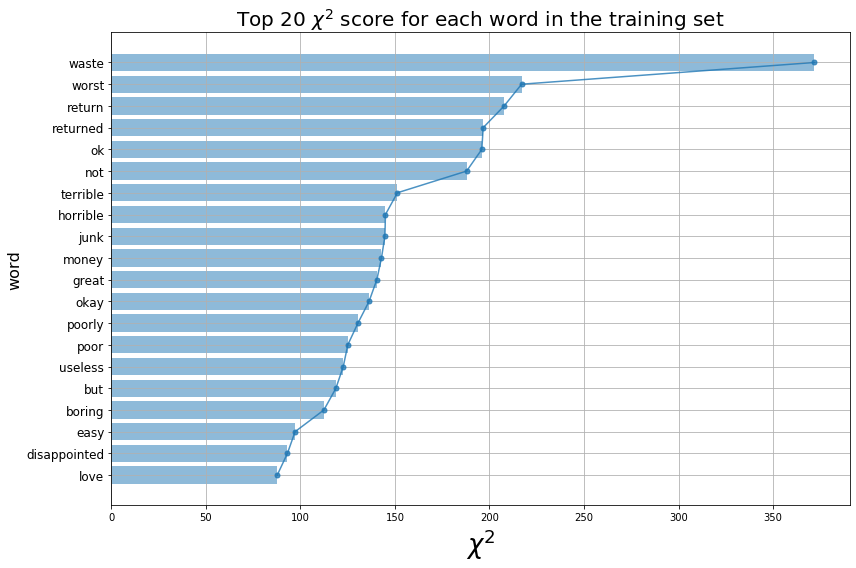

In [672]:
# Compute the chi-squared score for each word in the training set and show the values
i = 20

chi2score = chi2(X_train_, y_train)[0]
scores = list(zip(cv.get_feature_names(), chi2score))
sorted_scores = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*sorted_scores[-i:]))
x = range(len(topchi2[1]))
labels = topchi2[0]

plt.figure(figsize=(12, 8))
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels, fontsize=12)
plt.xlabel('$\chi^2$', fontsize=26)
plt.ylabel('word', fontsize=16)
plt.title('Top {} $\chi^2$ score for each word in the training set'.format(i), fontsize=20)
plt.grid()
plt.tight_layout()
plt.show();

### Entrenamiento

In [673]:
c_params = [0.01, 0.05, 0.25, 0.5, 1, 2, 5]

train_acc = list()
test_acc = list()
for c in c_params:
    lr = LogisticRegression(C=c, solver='lbfgs', max_iter=500)
    lr.fit(X_train_, y_train)
    
    train_predict = lr.predict(X_train_)
    test_predict = lr.predict(X_test_)
    
    print ("Accuracy for C={}: {}".format(c, accuracy_score(y_test, test_predict)))
    
    train_acc.append(accuracy_score(y_train, train_predict))
    test_acc.append(accuracy_score(y_test, test_predict))

Accuracy for C=0.01: 0.8293
Accuracy for C=0.05: 0.8347
Accuracy for C=0.25: 0.85345
Accuracy for C=0.5: 0.8577
Accuracy for C=1: 0.8589
Accuracy for C=2: 0.85865
Accuracy for C=5: 0.8573


### Algunas métricas

In [674]:
print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, test_predict)))
print('\nClassification report:\n{}'.format(classification_report(y_test, test_predict)))
print('Accuracy score:{}'.format(accuracy_score(y_test, test_predict)))

Confussion matrix:
[[  797   136   833]
 [  237   223  1188]
 [  248   212 16126]]

Classification report:
              precision    recall  f1-score   support

    negativo       0.62      0.45      0.52      1766
        otro       0.39      0.14      0.20      1648
    positivo       0.89      0.97      0.93     16586

    accuracy                           0.86     20000
   macro avg       0.63      0.52      0.55     20000
weighted avg       0.82      0.86      0.83     20000

Accuracy score:0.8573


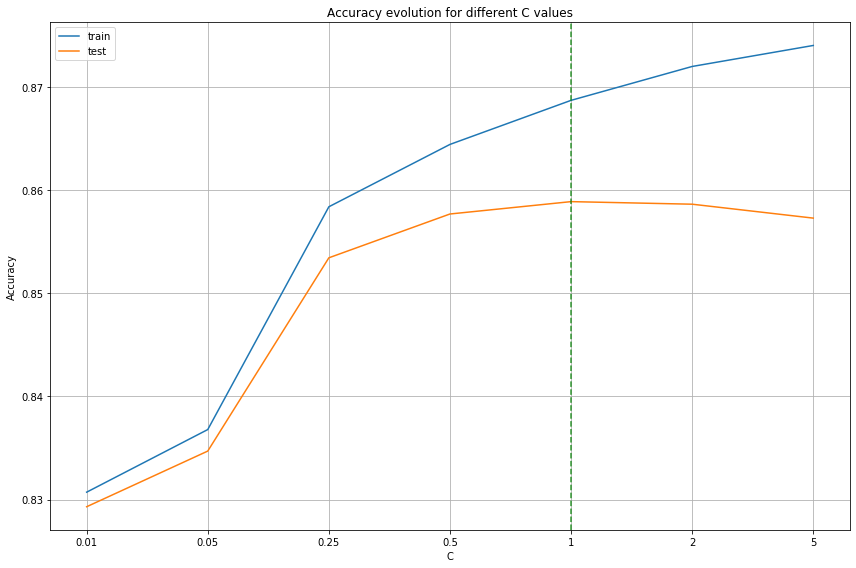

In [675]:
plt.figure(figsize=(12, 8))
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.axvline(np.argmax(test_acc), c='g', ls='--', alpha=0.8)
plt.title('Accuracy evolution for different C values')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.xticks(list(range(len(c_params))), c_params)
plt.tight_layout()
plt.show()

### Predict

In [676]:
def predict_review_sentiment(review_index, model):
    print('Actual sentiment: {}'.format(df.iloc[review_index]['sentiment_label']))
    r = df.iloc[review_index]['reviewText']
    print('Prediction: {}'.format(lr.predict(cv.transform([r]))))

In [677]:
for i in random.sample(range(0, len(df)), 10):
    print('\nReview no. {}'.format(i))
    predict_review_sentiment(i, lr)


Review no. 56754
Actual sentiment: positivo
Prediction: ['positivo']

Review no. 56338
Actual sentiment: positivo
Prediction: ['positivo']

Review no. 89528
Actual sentiment: positivo
Prediction: ['positivo']

Review no. 69683
Actual sentiment: otro
Prediction: ['negativo']

Review no. 29808
Actual sentiment: positivo
Prediction: ['positivo']

Review no. 46648
Actual sentiment: positivo
Prediction: ['positivo']

Review no. 16352
Actual sentiment: positivo
Prediction: ['positivo']

Review no. 28169
Actual sentiment: positivo
Prediction: ['positivo']

Review no. 86373
Actual sentiment: positivo
Prediction: ['positivo']

Review no. 35754
Actual sentiment: positivo
Prediction: ['positivo']


# Probamos balanceando los datos
# Quitamos los review de 3 ya que me dan peor resultado

In [701]:
df1 = pd.read_json('../../archivos/Automotive_5.json',lines=True)
df2 = pd.read_json('../../archivos/Video_Games_5.json',lines=True)
df3 = pd.read_json('../../archivos/Baby_5.json',lines=True)
df4 = pd.read_json('../../archivos/Home_and_Kitchen_5.json',lines=True)
df5 = pd.read_json('../../archivos/Sports_and_Outdoors_5.json',lines=True)

In [702]:
print('el df1 tiene',df1.shape)
print('el df2 tiene',df2.shape)
print('el df3 tiene',df3.shape)
print('el df4 tiene',df4.shape)
print('el df5 tiene',df5.shape)

el df1 tiene (20473, 9)
el df2 tiene (231780, 9)
el df3 tiene (160792, 9)
el df4 tiene (551682, 9)
el df5 tiene (296337, 9)


In [703]:
df=pd.concat([df1, df2, df3, df4, df5], axis=0)
df = shuffle(df)

In [704]:
df.shape

(1261064, 9)

In [705]:
df_neg =df[df['overall']<3]
df_neg.shape

(117344, 9)

In [706]:
df_pos =df[df['overall']>3]
df_pos = df_pos[:117344]

In [707]:
print('df_neg: ',df_neg.shape)
print('df_pos: ',df_pos.shape)

df_neg:  (117344, 9)
df_pos:  (117344, 9)


In [708]:
df=pd.concat([df_neg, df_pos], axis=0)
df = shuffle(df)
df.shape

(234688, 9)

In [709]:
def label_sentiment(row):
    if int(row['overall']) < 3:
        return 'negativo'
    else:
        return 'positivo'

In [710]:
df.overall.value_counts()

5    87428
1    59365
2    57979
4    29916
Name: overall, dtype: int64

In [711]:
df['sentiment_label'] = df.apply(lambda row: label_sentiment(row), axis=1)
df.drop(['reviewerID', 'asin', 'reviewerName', 'helpful', 'summary', 'unixReviewTime', 'reviewTime'], axis=1, inplace=True)

In [712]:
df.head()

,reviewText,overall,sentiment_label
235461,The Schwinn Elliptical frames flex a lot at th...,1,negativo
139047,I really researched this item before buying it...,5,positivo
282094,2014 JUN 22: OK Now it is clear.. There is a ...,1,negativo
93257,"I love this ""game"". It's a mixture of games t...",5,positivo
99255,I was so disappointed when we got this. It has...,1,negativo


### Pipeline

In [713]:
def text_normalizer(text, lemmatize=False, sw_list=None):
    
    processed_text = []
    
    if sw_list is None:
        sw_list = []
    
    if lemmatize:
        lemmas_dict = get_lemmas_dict()
    
    # Convierte el texto a minúsuculas
    text = text.lower()
    
    # Eliminar caracteres "extraños"
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    # Tabla para eliminar signos de puntuación
    table = str.maketrans('', '', string.punctuation)
    
    # Segmentar texto en frases
    sentences = text.split('.')
    
    # Para cada frase
    for sentence in sentences:
        words = sentence.split(' ')
        # Para cada palabra
        for word in words:
            if word not in string.punctuation and word not in sw_list:  # Si se pasa, elimina stop words
                word = word.translate(table)
                if lemmatize:
                    word = lemmas_dict.get(word, word)
                if word.isdigit():
                    word = num2words(word, lang='en')
            processed_text.append(word)
    
    return ' '.join(processed_text)

In [714]:
for text in df['reviewText']:
    text_normalizer(text)

### Separamos el conjunto de train y test

In [715]:
X_train, X_test, y_train, y_test = train_test_split(
    df['reviewText'],
    df['sentiment_label'],
    train_size=0.80,
    test_size=0.20,
    shuffle=True
)

### Extracción de features

In [716]:
cv = TfidfVectorizer(
    max_df=0.95,
    min_df=5,
    max_features=2500,
    strip_accents='ascii',
    #ngram_range=(1, 1)
    ngram_range=(1, 2) # con este ngram es con el que mejor resultado he obtenido en este modelo
    #ngram_range=(2, 3)
)
cv.fit(X_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.95, max_features=2500,
                min_df=5, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents='ascii',
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

### TF-IDF scores del training set y test set

In [717]:
X_train_ = cv.transform(X_train)
X_test_ = cv.transform(X_test)

### $\chi²$ scores

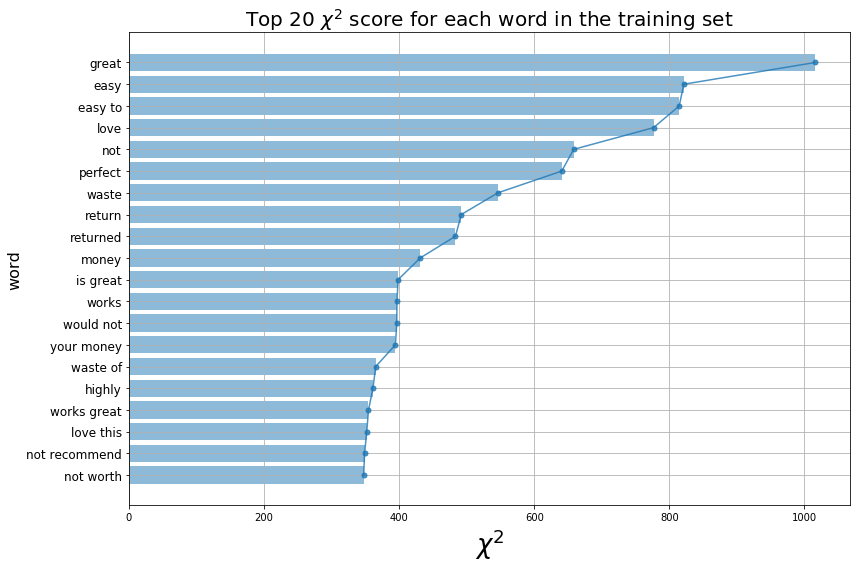

In [718]:
# Compute the chi-squared score for each word in the training set and show the values
i = 20

chi2score = chi2(X_train_, y_train)[0]
scores = list(zip(cv.get_feature_names(), chi2score))
sorted_scores = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*sorted_scores[-i:]))
x = range(len(topchi2[1]))
labels = topchi2[0]

plt.figure(figsize=(12, 8))
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels, fontsize=12)
plt.xlabel('$\chi^2$', fontsize=26)
plt.ylabel('word', fontsize=16)
plt.title('Top {} $\chi^2$ score for each word in the training set'.format(i), fontsize=20)
plt.grid()
plt.tight_layout()
plt.show();

### Entrenamiento

In [719]:
c_params = [0.01, 0.05, 0.25, 0.5, 1, 2, 5, 10, 100, 1000]

train_acc = list()
test_acc = list()
for c in c_params:
    lr = LogisticRegression(C=c, solver='lbfgs', max_iter=500)
    lr.fit(X_train_, y_train)
    
    train_predict = lr.predict(X_train_)
    test_predict = lr.predict(X_test_)
    
    print ("Accuracy for C={}: {}".format(c, accuracy_score(y_test, test_predict)))
    
    train_acc.append(accuracy_score(y_train, train_predict))
    test_acc.append(accuracy_score(y_test, test_predict))

Accuracy for C=0.01: 0.845839192125783
Accuracy for C=0.05: 0.8706591674123312
Accuracy for C=0.25: 0.8831650262047808
Accuracy for C=0.5: 0.8857002854829775
Accuracy for C=1: 0.8868507392730837
Accuracy for C=2: 0.8876816225659381
Accuracy for C=5: 0.8877668413652051
Accuracy for C=10: 0.8871916144701522
Accuracy for C=100: 0.8870637862712515
Accuracy for C=1000: 0.8870637862712515


### Algunas métricas

In [720]:
print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, test_predict)))
print('\nClassification report:\n{}'.format(classification_report(y_test, test_predict)))
print('Accuracy score:{}'.format(accuracy_score(y_test, test_predict)))

Confussion matrix:
[[20839  2640]
 [ 2661 20798]]

Classification report:
              precision    recall  f1-score   support

    negativo       0.89      0.89      0.89     23479
    positivo       0.89      0.89      0.89     23459

    accuracy                           0.89     46938
   macro avg       0.89      0.89      0.89     46938
weighted avg       0.89      0.89      0.89     46938

Accuracy score:0.8870637862712515


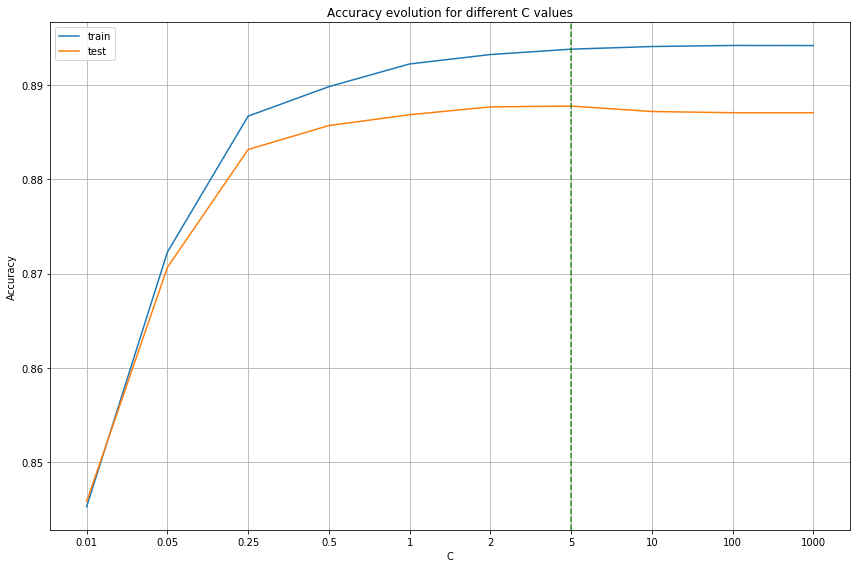

In [721]:
plt.figure(figsize=(12, 8))
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.axvline(np.argmax(test_acc), c='g', ls='--', alpha=0.8)
plt.title('Accuracy evolution for different C values')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.xticks(list(range(len(c_params))), c_params)
plt.tight_layout()
plt.show()

### Predict

In [722]:
def predict_review_sentiment(review_index, model):
    print('Actual sentiment: {}'.format(df.iloc[review_index]['sentiment_label']))
    r = df.iloc[review_index]['reviewText']
    print('Prediction: {}'.format(lr.predict(cv.transform([r]))))

In [723]:
for i in random.sample(range(0, len(df)), 10):
    print('\nReview no. {}'.format(i))
    predict_review_sentiment(i, lr)


Review no. 61670
Actual sentiment: negativo
Prediction: ['negativo']

Review no. 62870
Actual sentiment: positivo
Prediction: ['positivo']

Review no. 13201
Actual sentiment: negativo
Prediction: ['negativo']

Review no. 69953
Actual sentiment: negativo
Prediction: ['positivo']

Review no. 78543
Actual sentiment: negativo
Prediction: ['negativo']

Review no. 18650
Actual sentiment: positivo
Prediction: ['positivo']

Review no. 102077
Actual sentiment: positivo
Prediction: ['positivo']

Review no. 31083
Actual sentiment: positivo
Prediction: ['positivo']

Review no. 153231
Actual sentiment: positivo
Prediction: ['positivo']

Review no. 118268
Actual sentiment: positivo
Prediction: ['negativo']


# Conclusiones:
He realizado varias pruebas, y la conclusión es que hay que hacer un balanceo con los review, ya que hay más review positivos que negativos; también tendríamos que eliminar los review de 3, ya que, al no ser ni negativos ni positivos, empeoran el modelo. 